In [3]:

import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

warnings.filterwarnings("ignore")
randomseed = 7

Using TensorFlow backend.


In [4]:
data1 = pd.read_csv("NextYearData_actualData_train.txt")
data2 = pd.read_csv("ThisYearData_actualData_train.txt")
data3 = pd.read_csv("ThisYearData_actualData_test.txt")

data4 = pd.read_csv("NextYearData_actualData_test.txt")

data5 = pd.read_csv("Predicted_NextYearData.txt")
data5.columns = data4.columns

data = pd.concat([data1, data2, data3])

print(data.shape)
data.head()

(264810, 17)


,Unnamed: 0,FIELD_1,FIELD_2,L100700,S000300,L101700,L100800,L103000,L101300,L101600,L100500,FIELD_40,FIELD_38,FIELD_33,SEX,AGE,CLASS
0,0,55960,20171220,6.5,31.4,40.0,102.0,65.0,25.0,56.0,0.7,3.0,2.0,1.0,1.0,26.0,2
1,1,76211,20160715,5.5,32.3,30.0,82.0,76.0,22.0,75.0,0.9,2.0,1.0,1.0,0.0,25.0,2
2,2,99188,20150521,4.6,25.4,47.0,84.0,76.0,14.0,65.0,1.0,3.0,6.0,1.0,0.0,25.0,2
3,3,101815,20171125,6.5,37.4,24.0,94.0,65.0,28.0,41.0,0.9,0.0,1.0,3.0,0.0,27.0,2
4,4,121902,20141120,6.4,31.5,24.0,128.0,87.0,42.0,60.0,0.8,2.0,1.0,1.0,0.0,25.0,2


In [5]:
class2 = data[data.CLASS == 2]
class1 = data[data.CLASS == 1]
class0 = data[data.CLASS == 0]

print(class2.shape[0], class1.shape[0], class0.shape[0])

8604 120990 135216


In [6]:
class2_test = class2.sample(200, random_state=randomseed)
class1_test = class1.sample(200, random_state=randomseed)
class0_test = class0.sample(200, random_state=randomseed)
test = pd.concat([class2_test, class1_test, class0_test])

class2_train = class2.drop(class2_test.index)
class1_train = class1.drop(class1_test.index).sample(
    2 * class2_train.shape[0], random_state=randomseed
)
class0_train = class0.drop(class0_test.index).sample(
    2 * class2_train.shape[0], random_state=randomseed
)
train = pd.concat([class2_train, class2_train, class1_train, class0_train])

In [7]:
xtrain = train.iloc[:, 3:-1]
ytrain = train.iloc[:, -1]
xtest = test.iloc[:, 3:-1]
ytest = test.iloc[:, -1]

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.5716666666666667


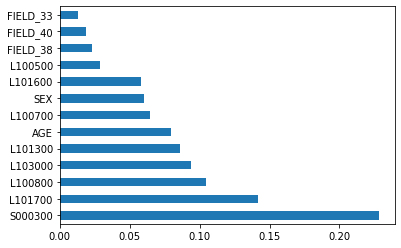

Index(['S000300', 'L101700', 'L100800', 'L103000', 'L101300', 'AGE', 'L100700',
       'SEX', 'L101600', 'L100500', 'FIELD_38', 'FIELD_40', 'FIELD_33'],
      dtype='object')


In [10]:
ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, 3:-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

In [11]:
print("Accuracy on training set: {:.3f}".format(rf.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

Accuracy on training set: 0.703
Accuracy on test set: 0.572


,0,1,2
0,132,50,18
1,60,76,64
2,12,53,135


In [12]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65       200
           1       0.42      0.38      0.40       200
           2       0.62      0.68      0.65       200

    accuracy                           0.57       600
   macro avg       0.56      0.57      0.57       600
weighted avg       0.56      0.57      0.57       600



In [13]:
# =====================================
pred5 = rf.predict((data5.iloc[:, 3:-2]))

# temp=data5.iloc[:,3:-2]
# temp.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
# pred5= xgb_model.predict((temp))

print(m.accuracy_score(data5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(data5.iloc[:, -1], pred5))
confmatrx

accuracy 	 0.545


,0,1,2
0,136,45,19
1,60,62,78
2,13,58,129


In [14]:
print(classification_report(data5.iloc[:, -1], pred5))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       200
           1       0.38      0.31      0.34       200
           2       0.57      0.65      0.61       200

    accuracy                           0.55       600
   macro avg       0.53      0.55      0.54       600
weighted avg       0.53      0.55      0.54       600



In [13]:
# =====================================
pred5 = rf.predict((data5.iloc[:, 3:-2]))

# temp=data5.iloc[:,3:-2]
# temp.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
# pred5= xgb_model.predict((temp))

print(m.accuracy_score(data5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(data5.iloc[:, -1], pred5))
confmatrx

0.660860491250602


,0,1,2
0,5590,2956,34
1,955,2468,219
2,3,58,175


<IPython.core.display.Javascript object>

In [14]:
print(classification_report(data5.iloc[:, -1], pred5))

              precision    recall  f1-score   support

           0       0.85      0.65      0.74      8580
           1       0.45      0.68      0.54      3642
           2       0.41      0.74      0.53       236

    accuracy                           0.66     12458
   macro avg       0.57      0.69      0.60     12458
weighted avg       0.73      0.66      0.68     12458



<IPython.core.display.Javascript object>

In [15]:
# ========================================================

<IPython.core.display.Javascript object>

In [16]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

<IPython.core.display.Javascript object>

In [17]:
y_pred = neigh.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.56


,0,1,2
0,125,44,31
1,62,73,65
2,9,53,138


<IPython.core.display.Javascript object>

In [18]:
pred5 = neigh.predict((data5.iloc[:, 3:-2]))


print(m.accuracy_score(data5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(data5.iloc[:, -1], pred5))
confmatrx

0.5179001444854712


,0,1,2
0,4989,2195,1396
1,941,1308,1393
2,13,68,155


<IPython.core.display.Javascript object>